# PROBLEMA DE UNIT COMMITMENT DETERMINÍSTICO

**Alunos**: Luana Gaspar e Thiago Novaes

**Data**: 13 de outubro de 2022

## 1. Modelo

O modelo implementado segue a formulação do relatório "TAREFAS 1.1 E 1.2 - PROBLEMA DE UNIT COMMITMENT DETERMINÍSTICO" enviado pela monitora. A formulação é a seguinte:
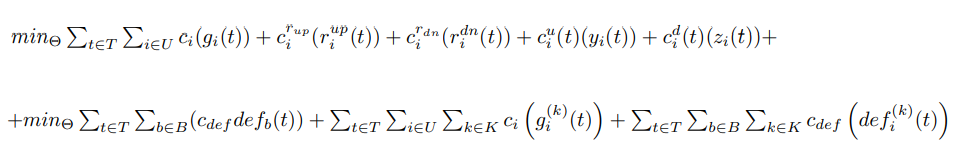

Sujeito a:

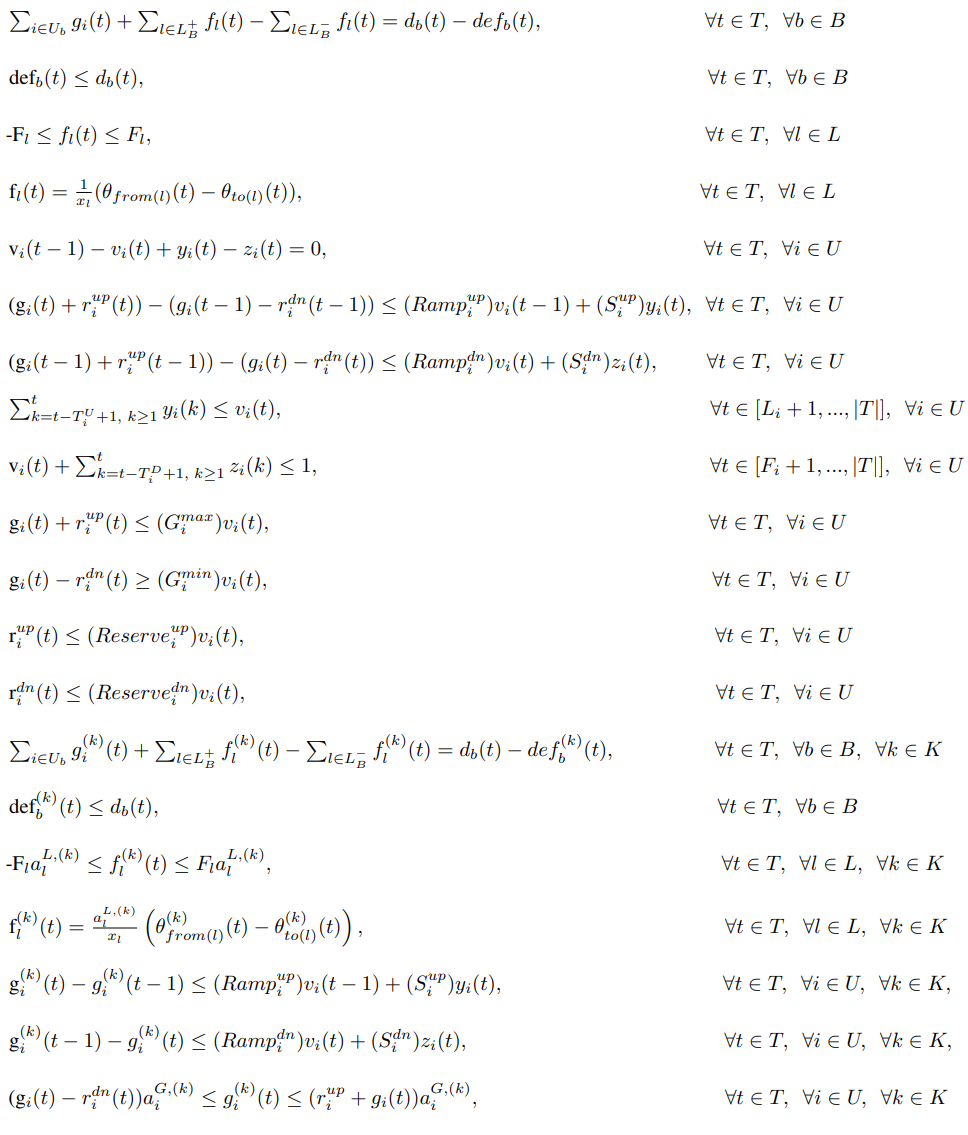

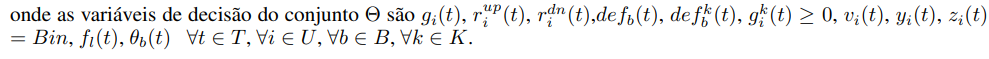

## 2. Implementação
A implementação foi desenvolvida no repositorio https://github.com/Thiago-NovaesB/UnitCommitment.jl <br>
O arquivo principal do modulo apenas importa todos os arquivos realmente contendo a implementação, sendo eles:

* utils.jl
* types.jl
* variables.jl
* constraints.jl
* model.jl

### 2.1 utils.jl
Possui apenas a definição da macro <b>@kwdef</b>, ela cria valores default para as structs.

### 2.2 types.jl
Possui a definição de todas as structs usadas pelo pacote. Essas structs guardam os dados do sistema, as opções de execução, os tamanhos das coleções etc. Por exemplo a struct de opções de execução:
```
@kwdef mutable struct Options
    solver::Union{DataType,Nothing} = nothing
    use_kirchhoff::Bool
    use_ramp::Bool
    use_commit::Bool
    use_up_down_time::Bool
    use_contingency::Bool
end
```

### 2.3 variables.jl
Este arquivo possui uma função para cada variavel que o modelo pode ter. Cada função é responsavel por verificar as opções e dados para criar corretamente as variaveis. Por exemplo, a função abaixo é a responsavel por criar os angulos nas barras, para isso ela checa se a segunda lei de kirchhoff està ativa:

```
function add_theta!(prb::Problem)
    model = prb.model
    size = prb.size
    options = prb.options
    if options.use_kirchhoff
        @variable(model, theta[1:size.bus, 1:size.stages])
    end
end
```

### 2.4 constraints.jl
Este arquivo possui uma função para cada restrição que o modelo pode ter. Cada função é responsavel por verificar as opções e dados para criar corretamente as restrições. Por exemplo, a função abaixo é a responsavel por criar a segunda lei de kirchhoff pos contigência, para isso ela checa se a segunda lei de kirchhoff està ativa e se contingências estão ativas:
```
function add_KVL_pos!(prb::Problem)
    model = prb.model
    data = prb.data
    size = prb.size
    options = prb.options

    if options.use_contingency && options.use_kirchhoff
        f_pos = model[:f_pos]
        theta_pos = model[:theta_pos]
        @constraint(model, KVL_pos[i in 1:size.circ, t in 1:size.stages, k=1:size.K], f_pos[i, t, k] == data.contingency_lin[i, k] * sum(theta_pos[j, t, k] * data.A[j, i] for j in 1:size.bus) / data.x[i])
    end
end
```
Para facilitar a obtenção das duais, a tecnica de "pescadora de dual" foi utilizada. Ou seja, a demanda foi inserida como uma variavel auxuliar e uma restrição que diz que a variavel auxiliar é igual a demanda também foi inserida, isolando assim o aparecimento da demanda no problema:

```
function add_DUAL_FISHER!(prb::Problem)
    model = prb.model
    data = prb.data
    size = prb.size

    fake_demand = model[:fake_demand]

    @constraint(model, DUAL_FISHER[i=1:size.bus, t=1:size.stages], fake_demand[i,t] == data.demand[i,t])
end
```

### 2.5 model.jl
Este arquivo possui funções como criação do modelo, definição da função objetivo e chamada do otimizador. Algumas funções adicionais foram implementadas para conseguir as variaveis duais de problemas com variaveis inteiras. Para isso, resolvemos o problema com varaiveis inteiras, fixamos as variaveis em seus valores otimos e depois resolvemos o problema sem varaiveis inteiras. As funções que possibilitam isso estão abaixo:

```
function build_model(prb::Problem)

    options = prb.options
    prb.model = Model(options.solver)
    JuMP.MOI.set(prb.model, JuMP.MOI.Silent(), true)

    add_variables!(prb)
    add_constraints!(prb)
    objective_function!(prb)
    nothing
end

function rerun_model(prb::Problem)
    model = prb.model

    c = value.(model[:c])
    @constraint(model, model[:c] .== c)
    unset_binary.(model[:c])

    solve_model(prb)
    nothing
end

function solve_model(prb::Problem)

    optimize!(prb.model)
    nothing
end
```

## 3. Resultados

O código implementado foi testado em diversos cenários, são eles:
1. Uma barra e 3 geradores sem reserva endógena por um horizonte de 6 horas
2. Uma barra e 3 geradores com reserva endógena de subida por um horizonte de 6 horas
3. Uma barra e 3 geradores com reserva endógena de subida e descida por um horizonte de 6 horas
4. Seis barras e 3 geradores sem reserva por um horizonte de 6 horas
5. Seis barras, com rede restrita, e 3 geradores sem reserva por um horizonte de 6 horas
6. Seis barras, com rede restrita, e 3 geradores com reserva de subida e descida por um horizonte de 6 horas
7. Seis barras e 3 geradores com reserva de subida e descida e contingência k-1 por um horizonte de 6 horas

### 3.1 Primeiro cenário
Uma barra e 3 geradores sem reserva endógena por um horizonte de 6 horas

In [2]:
include("examples/example2_6_1.jl")

Custo total do sistema:  9475.0

Geração:
170.0	200.0	200.0	170.0	200.0	190.0
70.0	50.0	0.0	0.0	0.0	0.0
-0.0	0.0	0.0	0.0	30.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
1000.0	5.0	5.0	5.0	5.0	5.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Deficit:
-0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	-0.0	0.0	0.0	0.0
-0.0	0.0	0.0	-0.0	1.0	-0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida e de descida:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)


Como pode ser percebido, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.1 do relatório enviado pela monitora, com exceção da variável dual do primeiro estágio. Nesse caso, qualquer MWh a mais de demanda teria que ser "atendido" pelo deficit, já que neste primeiro momento é utilizada a capacidade máxima de rampa do gerador 1 e a capacidade máxima de ligamento do gerador 2, enquanto o gerador 3 está desligado. Assim, a função encontra-se em um ponto de descontinuidade em que qualquer MWh a mais causaria deficit, cujo custo é 1000 reais por MWh, porém qualquer MWh a menos causaria uma redução na geração do gerador 2, cujo custo é 15 reais por MWh. Assim, os dois valores são válidos para a variável dual.

### 3.2 Segundo cenário
Uma barra e 3 geradores com reserva endógena de subida por um horizonte de 6 horas

In [3]:
include("examples/example2_6_2.jl")

Custo total do sistema:  11800.0

Geração:
160.0	170.0	150.0	170.0	200.0	190.0
50.0	80.0	50.0	0.0	0.0	0.0
30.0	0.0	0.0	0.0	30.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
5.0	15.0	-5.0	5.0	5.0	5.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	1.0	-0.0	0.0	0.0
1.0	-0.0	0.0	-0.0	1.0	-0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida:
10.0	10.0	10.0	10.0	10.0	10.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)


Neste caso, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.2 do relatório enviado pela monitora.

### 3.3 Terceiro cenário
Uma barra e 3 geradores com reserva endógena de subida e descida por um horizonte de 6 horas

In [4]:
include("examples/example2_6_3.jl")

Custo total do sistema:  12500.0

Geração:
160.0	160.0	150.0	170.0	200.0	190.0
50.0	90.0	50.0	0.0	0.0	0.0
30.0	0.0	0.0	0.0	30.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
5.0	15.0	-5.0	5.0	5.0	5.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	1.0	-0.0	0.0	0.0
1.0	-0.0	0.0	-0.0	1.0	-0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida:
10.0	10.0	10.0	10.0	10.0	10.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de descida:
10.0	10.0	10.0	10.0	10.0	10.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)


Neste caso, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.3 do relatório enviado pela monitora.

### 3.4 Quarto cenário
Seis barras e 3 geradores sem reserva por um horizonte de 6 horas

In [5]:
include("examples/example2_6_4.jl")

Custo total do sistema:  9475.0

Geração:
170.0	200.0	200.0	170.0	200.0	190.0
70.0	50.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	30.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
15.0	5.0	5.0	5.0	5.0	5.0
15.0	5.0	5.0	5.0	5.0	5.0
15.0	5.0	5.0	5.0	5.0	5.0
15.0	5.0	5.0	5.0	5.0	5.0
15.0	5.0	5.0	5.0	5.0	5.0
15.0	5.0	5.0	5.0	5.0	5.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	-0.0	0.0	0.0	0.0
0.0	0.0	0.0	-0.0	1.0	-0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida e de descida:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Fluxos:
-66.67	-75.0	-73.33	-98.33	-83.33	-71.67
-58.33	-70.83	-70.0	-40.83	-66.

Neste caso, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.4 do relatório enviado pela monitora. A única diferença está no padrão de sinal utilizado para os fluxos.

### 3.5 Quinto cenário
Seis barras, com rede restrita, e 3 geradores sem reserva por um horizonte de 6 horas

In [6]:
include("examples/example2_6_5.jl")

Custo total do sistema:  11675.0

Geração:
160.0	157.5	147.5	120.0	162.5	137.5
50.0	92.5	52.5	50.0	67.5	52.5
30.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
5.0	5.0	5.0	5.0	5.0	5.0
5.0	25.0	5.0	5.0	15.0	15.0
5.0	30.0	5.0	5.0	17.5	17.5
5.0	15.0	5.0	5.0	10.0	10.0
5.0	20.0	5.0	5.0	12.5	12.5
5.0	40.0	5.0	5.0	22.5	22.5
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	1.0	1.0	1.0	1.0
1.0	-0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida e de descida:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Fluxos:
-68.33	-60.83	-55.83	-81.67	-65.83	-54.17
-52.5	-56.67	-52.5

Neste caso, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.5 do relatório enviado pela monitora. A única diferença está no padrão de sinal utilizado para os fluxos.

### 3.6 Sexto cenário
Seis barras, com rede restrita, e 3 geradores com reserva de subida e descida por um horizonte de 6 horas

In [7]:
include("examples/example2_6_6.jl")

Custo total do sistema:  13325.0

Geração:
160.0	150.0	140.0	120.0	147.5	137.5
50.0	100.0	60.0	50.0	82.5	52.5
30.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
15.0	15.0	15.0	-15.0	15.0	-5.0
15.0	15.0	15.0	-15.0	15.0	15.0
15.0	15.0	15.0	-15.0	15.0	20.0
15.0	15.0	15.0	-15.0	15.0	5.0
15.0	15.0	15.0	-15.0	15.0	10.0
15.0	15.0	15.0	-15.0	15.0	30.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	1.0	1.0	1.0	1.0
1.0	-0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida:
10.0	10.0	0.0	10.0	10.0	10.0
0.0	0.0	10.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de descida:
10.0	10.0	10.0	10.0	10.0	10.

Neste caso, os resultados obtidos foram os mesmos dos apresentados na seção 2.6.6 do relatório enviado pela monitora. As diferenças são: o padrão de sinal utilizado para os fluxos e a dual do primeiro estágio. Como explicado anteriormente, isso acontece por causa de uma descontinuidade na função de custo.

### 3.7 Sétimo cenário
Seis barras e 3 geradores com reserva de subida e descida e contingência k-1 por um horizonte de 6 horas

In [8]:
include("examples/example3_1.jl")

Custo total do sistema, considerando contingências:  5.291606e6

Geração:
122.5	120.0	110.0	100.0	113.3	83.3
70.0	50.0	-0.0	-0.0	66.7	56.7
40.0	80.0	90.0	70.0	50.0	50.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Dual:
19905.0	290.0	135.0	4875.0	10095.0	-9895.0
31038.0	15220.0	11452.0	4962.0	15125.0	150.0
31946.0	15225.0	11452.0	4900.0	15128.0	150.0
31926.0	25150.0	11453.0	20202.0	25075.0	150.0
28992.0	10252.0	7680.0	4912.0	13453.0	-3198.0
34900.0	20198.0	15225.0	4888.0	16802.0	3498.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Deficit:
0.0	0.0	0.0	0.0	0.0	0.0
7.5	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
0.0	0.0	0.0	0.0	0.0	0.0
*colunas: horas (de 1 a 6); linhas: barras (1 a 6)

Status dos geradores:
1.0	1.0	1.0	1.0	1.0	1.0
1.0	1.0	-0.0	-0.0	1.0	1.0
1.0	1.0	1.0	1.0	1.0	1.0
*colunas: horas (de 1 a 6); linhas: geradores (do 1 ao 3)

Reserva de subida:
7.5	5.0	0.0	26.7	0.0	40.0
0.0	0.0	0.0	0.0	3.3	50.0
0.0	20.0	10.0

Neste caso, os resultados obtidos para as gerações foram similares aos encontrados pela monitora. Existem diferenças em outros dados. As duais apresentam muita diferença, isso pode ser devido a pontos degenerados, como visto anteriormente. Ou o documento de referência apenas pegou as duais do regime pré contingência. Neste trabalho, a pescadora de dual foi usada para realmente buscar o custo marginal da demanda, ou seja, considerando o aparecimento da demanda na contingência.

Os fluxos também apresentam diferença nos sinais. Além da diferenàa de sinais nos fluxos, também existem diferenças em alguns valores, assim como no defict pós contingência. porém como é facil verificar, o balanço de demanda não é atendido no documento de refência. No estagio 4, são gerados 100 pós contingência com defict pós contingência nulo. Ou seja, existe um erro no documento de refência, oque explica as diferenças encontradas.